<a href="https://colab.research.google.com/github/jcandane/HF_Gradient/blob/main/PySCF_Gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nuclear Gradients of AO Integrals in PySCF

Let's begin by importing packages

In [ ]:
!pip install pyscf 

import numpy as np
import matplotlib.pyplot as plt
from pyscf import scf, gto

np.set_printoptions(precision=6, linewidth=200, threshold=2000, suppress=True)

     |████████████████████████████████| 37.5 MB 1.2 MB/s 


Let's Setup the Water Molecule with PySCF

In [ ]:
h2o = gto.Mole()
h2o.verbose = 0
h2o.atom = [
    ['O' , (0. , 0.     , 0.)],
    [1   , (0. , -0.757 , 0.587)],
    [1   , (0. , 0.757  , 0.587)] ]
h2o.basis = {'H': 'sto-3g',
             'O': 'sto-3g',}
h2o.build()
H20_HF = scf.RHF(h2o)
H20_HF.conv_tol = 1e-14
e0 = H20_HF.scf()
print(e0)

-74.96306312972916


Let's Import, prebuilt functions:

In [ ]:
def h_deriv(atom_id, h1, mol):
    shl0, shl1, p0, p1 = (mol.aoslice_by_atom())[atom_id]
    with mol.with_rinv_at_nucleus(atom_id):
        vrinv  = (-mol.atom_charge(atom_id)) * mol.intor('int1e_iprinv', comp=3) # <\nabla|1/r|>
        vrinv += mol.intor('ECPscalar_iprinv', comp=3)
    vrinv[:,p0:p1] += h1[:,p0:p1]
    return vrinv + vrinv.swapaxes(1,2) 
def S_deriv(atom_id, S_xAB, mol):
    shl0, shl1, p0, p1 = (mol.aoslice_by_atom())[atom_id]

    vrinv = np.zeros(S_xAB.shape)
    vrinv[:, p0:p1, :] += S_xAB[:, p0:p1, :]
    
    return vrinv + vrinv.swapaxes(1,2)
def I_deriv(atom_id, I_xABCD, mol):
    shl0, shl1, p0, p1 = (mol.aoslice_by_atom())[atom_id]

    vrinv  = np.zeros(I_xABCD.shape)
    vrinv[:, p0:p1, :, :, :] += I_xABCD[:, p0:p1, :, :, :]
    
    vrinv += np.einsum("xABCD -> xCDAB", vrinv) 
    vrinv += np.einsum("xABCD -> xBACD", vrinv) 
    vrinv += np.einsum("xABCD -> xABDC", vrinv)
    vrinv += np.einsum("xABCD -> xBADC", vrinv)
    
    return vrinv/4.

In [ ]:
h_xAB    = -h2o.intor('ECPscalar_ipnuc', comp=3)
h_xAB   += -h2o.intor('int1e_ipkin', comp=3)
h_xAB   += -h2o.intor('int1e_ipnuc', comp=3)
S_xAB    = -h2o.intor('int1e_ipovlp', comp=3)
I_xABCD  = -h2o.intor('int2e_ip1', comp=3)
dI_pyscf = np.zeros(((len(h2o.aoslice_by_atom()),) + I_xABCD.shape))
dH_pyscf = np.zeros(((len(h2o.aoslice_by_atom()),) + h_xAB.shape))
dS_pyscf = np.zeros(((len(h2o.aoslice_by_atom()),) + S_xAB.shape))
for i in range(len(h2o.aoslice_by_atom())):
    dI_pyscf[i] = I_deriv(i, I_xABCD, h2o)
    dS_pyscf[i] = S_deriv(i, S_xAB, h2o)
    dH_pyscf[i] = h_deriv(i, h_xAB, h2o)

In [ ]:
print(dH_pyscf[1,1])

[[-0.24116  -0.057084  0.        0.007479 -0.012439 -1.743896 -0.013067]
 [-0.057084 -0.21881   0.        0.06568  -0.12905  -2.640749 -0.088277]
 [ 0.        0.       -0.178782  0.        0.        0.        0.      ]
 [ 0.007479  0.06568   0.       -0.21376   0.069363  0.470044 -0.02343 ]
 [-0.012439 -0.12905   0.        0.069363 -0.265322 -1.55448  -0.07679 ]
 [-1.743896 -2.640749  0.        0.470044 -1.55448  -1.715006 -1.360205]
 [-0.013067 -0.088277  0.       -0.02343  -0.07679  -1.360205 -0.118652]]


In [ ]:
print(dI_pyscf[1,1,1,1])

[[ 0.        0.        0.        0.        0.        0.058066  0.      ]
 [ 0.        0.        0.        0.        0.        0.221006  0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.       -0.046216  0.      ]
 [ 0.        0.        0.        0.        0.        0.143113  0.      ]
 [ 0.058066  0.221006  0.       -0.046216  0.143113  0.150351  0.11779 ]
 [ 0.        0.        0.        0.        0.        0.11779   0.      ]]


In [ ]:
print(dS_pyscf[1,1])

[[ 0.        0.        0.        0.        0.        0.05348   0.      ]
 [ 0.        0.        0.        0.        0.        0.274295  0.      ]
 [ 0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.       -0.033438  0.      ]
 [ 0.        0.        0.        0.        0.        0.194362  0.      ]
 [ 0.05348   0.274295  0.       -0.033438  0.194362  0.        0.191429]
 [ 0.        0.        0.        0.        0.        0.191429  0.      ]]


Let's try something with an ECP potential!

In [ ]:
h2o = gto.Mole()
h2o.verbose = 0
h2o.atom = [
    ['O' , (0. , 0.     , 0.)],
    [1   , (0. , -0.757 , 0.587)],
    [1   , (0. , 0.757  , 0.587)] ]
h2o.basis = {'H': 'sto-3g',
             'O': 'lanl2dz',}
h2o.build()
H20_HF = scf.RHF(h2o)
H20_HF.conv_tol = 1e-14
e0 = H20_HF.scf()

Now lets define a method for this: 

In [ ]:
def dints(mol):
    h_xAB    = -mol.intor('ECPscalar_ipnuc', comp=3)
    h_xAB   += -mol.intor('int1e_ipkin', comp=3)
    h_xAB   += -mol.intor('int1e_ipnuc', comp=3)
    S_xAB    = -mol.intor('int1e_ipovlp', comp=3)
    I_xABCD  = -mol.intor('int2e_ip1', comp=3)
    dI_pyscf = np.zeros(((len(mol.aoslice_by_atom()),) + I_xABCD.shape))
    dH_pyscf = np.zeros(((len(mol.aoslice_by_atom()),) + h_xAB.shape))
    dS_pyscf = np.zeros(((len(mol.aoslice_by_atom()),) + S_xAB.shape))
    for i in range(len(mol.aoslice_by_atom())):
        dI_pyscf[i] = I_deriv(i, I_xABCD, mol)
        dS_pyscf[i] = S_deriv(i, S_xAB, mol)
        dH_pyscf[i] = h_deriv(i, h_xAB, mol)
    return dI_pyscf, dS_pyscf, dH_pyscf

In [ ]:
def Bohr(x): ### given Ångström get Bohr
    return 1.889726125 * x 

def Ångström(x): ### given Bohr get Ångström
    return x / 1.889726125

def get_UFock(I, H, Da, Db):
    J  = np.einsum("mnrs, rs -> mn", I, Da + Db , optimize=True)
    Kα = np.einsum("mnrs, nr -> ms", I, Da , optimize=True)
    Kβ = np.einsum("mnrs, nr -> ms", I, Db , optimize=True)
    Fα = H + J - Kα
    Fβ = H + J - Kβ
    return Fα,  Fβ

def get_Euhf(H, DA, DB, FA, FB):
    Euhf  = np.einsum("pq,pq->", DA + DB, H)
    Euhf += np.einsum("pq,pq->", DA, FA)
    Euhf += np.einsum("pq,pq->", DB, FB)
    Euhf *= 0.5
    return Euhf

def get_force(dI, dS, dH, DA, DB, FA, FB):
    D = DA + DB    

    ## Hellman Feynman
    fix  = -1.0*np.einsum("mn, IXmn -> IX",  D, dH)
    fix -=  0.5*np.einsum("nm, ls, IXmnls -> IX",  D,  D, dI, optimize=True) ## dJ
    fix +=  0.5*np.einsum("nm, ls, IXmlsn -> IX", DA, DA, dI, optimize=True) ## dKα
    fix +=  0.5*np.einsum("nm, ls, IXmlsn -> IX", DB, DB, dI, optimize=True) ## dKβ

    ## Pulay
    fix += 1.0*np.einsum("ij, IXjk, kl, il -> IX", DA, dS, DA, FA, optimize=True)
    fix += 1.0*np.einsum("ij, IXjk, kl, il -> IX", DB, dS, DB, FB, optimize=True)

    return fix

def grad_nuc(mol, atmlst=None):
    '''
    Author: Qiming Sun <osirpt.sun@gmail.com>
    Derivatives of nuclear repulsion energy wrt nuclear coordinates
    '''
    gs = np.zeros((mol.natm,3))
    for j in range(mol.natm):
        q2 = mol.atom_charge(j)
        r2 = mol.atom_coord(j)
        for i in range(mol.natm):
            if i != j:
                q1 = mol.atom_charge(i)
                r1 = mol.atom_coord(i)
                r = np.sqrt(np.dot(r1-r2,r1-r2))
                gs[j] -= q1 * q2 * (r2-r1) / r**3
    if atmlst is not None:
        gs = gs[atmlst]
    return gs

In [ ]:
def get_f_ix(mol, DA, DB, FA, FB):
    """
    GIVEN:
    mol : PySCF mol object
    DA, DB: AO Density Matrices (2d numpy arrays)
    FA, FB: AO Fock Matrices (2d numpy arrays)
    GET:
    HF force between atoms
    """
    h_xAB    = -mol.intor('ECPscalar_ipnuc', comp=3)
    h_xAB   += -mol.intor('int1e_ipkin', comp=3)
    h_xAB   += -mol.intor('int1e_ipnuc', comp=3)
    S_xAB    = -mol.intor('int1e_ipovlp', comp=3)
    I_xABCD  = -mol.intor('int2e_ip1', comp=3)
    ff_ix    = np.zeros( (len(mol.aoslice_by_atom()), 3) )
    for i in range(len(mol.aoslice_by_atom())):
        dI_x = I_deriv(i, I_xABCD, mol)
        dS_x = S_deriv(i, S_xAB, mol)
        ff_ix[i]  = -1.0*np.einsum("mn, Xmn -> X",  DA+DB, h_deriv(i, h_xAB, mol))
        ff_ix[i] -=  0.5*np.einsum("nm, ls, Xmnls -> X", DA+DB, DA+DB, dI_x, optimize=True) ## dJ
        ff_ix[i] +=  0.5*np.einsum("nm, ls, Xmlsn -> X", DA, DA, dI_x, optimize=True) ## dKα
        ff_ix[i] +=  0.5*np.einsum("nm, ls, Xmlsn -> X", DB, DB, dI_x, optimize=True) ## dKβ

        ## Pulay
        ff_ix[i] += 1.0*np.einsum("ij, Xjk, kl, il -> X", DA, dS_x, DA, FA, optimize=True)
        ff_ix[i] += 1.0*np.einsum("ij, Xjk, kl, il -> X", DB, dS_x, DB, FB, optimize=True)

    return ff_ix

In [ ]:
dI, dS, dH = dints(h2o)

Let's Scan OH (with 9 electrons) with UHF and compare the Numerical and Analytical Gradient.

In [ ]:
dx       = 0.05
distance = np.arange(0.5, 2.7, dx) ## in Ångströms
force    = np.zeros(distance.shape)
energy   = np.zeros(distance.shape)
energyA  = np.zeros(distance.shape)

oh = gto.Mole()
oh.verbose = 0
oh.atom = [
    ['O' , (0. , 0.     , 0.)],
    [1   , (0. , 0. , 0.45)]]
oh.spin = 1
oh.basis = {"H": "sto-3g",
             "O": "lanl2dz",}
oh.build()
OH_UHF = scf.UHF(oh)
OH_UHF.conv_tol = 1e-12
OH_UHF.kernel()
DA, DB = oh.make_rdm1()

for i in range(len(distance)):
    
    oh = gto.Mole()
    oh.verbose = 0
    oh.atom = [
        ['O' , (0. , 0.     , 0.)],
        [1   , (0. , 0. , distance[i])]]
    oh.spin = 1
    oh.basis = {"H": "sto-3g",
                 "O": "lanl2dz",}
    oh.build()
    OH_UHF = scf.UHF(oh)
    OH_UHF.conv_tol = 1e-12
    OH_UHF.kernel((DA, DB))
    energy[i] = OH_UHF.scf()
    
    dmA, dmB = oh.make_rdm1()
    II = oh.intor("int2e")
    H  = oh.intor("int1e_kin") + oh.intor("int1e_nuc") + oh.intor("ECPscalar") ### get ECP!!!
    
    FA, FB = get_UFock(II, H, dmA, dmB)
    energyA[i] = get_Euhf(H, dmA, dmB, FA, FB) + oh.energy_nuc()
    
    dI, dS, dH = dints(oh)
    force[i] = (get_force(dI, dS, dH, dmA, dmB, FA, FB) - grad_nuc(oh))[0,2]
    
    DA = dmA
    DB = dmB

In [ ]:
fmol_ix = get_f_ix(oh, DA, DB, FA, FB)
fall_ix = get_force(dI, dS, dH, dmA, dmB, FA, FB)
np.allclose( fmol_ix , fall_ix )
fmol_ix

array([[ 0.      ,  0.      ,  0.380997],
       [-0.      , -0.      , -0.380997]])

In [ ]:
energyA - energy

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0., -0., -0., -0., -0.,  0., -0., -0., -0.,
        0., -0., -0., -0., -0.,  0.])

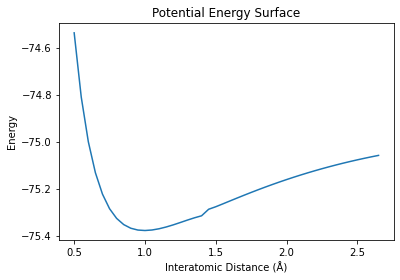

In [ ]:
plt.plot(distance, energy, "-")
plt.title("Potential Energy Surface")
plt.xlabel("Interatomic Distance (Å)")
plt.ylabel("Energy")
plt.show()

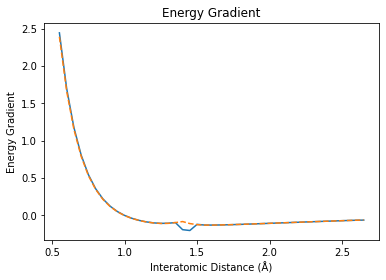

In [ ]:
plt.plot(distance[1:], (-np.gradient(energy, Bohr(dx)))[1:], "-")
plt.plot(distance[1:], -force[1:], linestyle="dashed")
plt.title("Energy Gradient")
plt.xlabel("Interatomic Distance (Å)")
plt.ylabel("Energy Gradient")
plt.show()

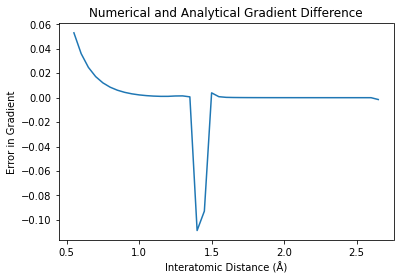

In [ ]:
plt.plot(distance[1:], (-np.gradient(energy, Bohr(dx)))[1:] + (force)[1:] , "-")
plt.title("Numerical and Analytical Gradient Difference")
plt.xlabel("Interatomic Distance (Å)")
plt.ylabel("Error in Gradient")
plt.show()

## Export to HF_gradient.py

In [ ]:
!git clone https://github.com/jcandane/pyprototyp
from pyprototyp.pyprototyp import pyprototyp

pyprototyp("HF_gradient", packages=[], useful=[], defs=[h_deriv, S_deriv, I_deriv, get_f_ix], classes=[])

fatal: destination path 'pyprototyp' already exists and is not an empty directory.
